In [1]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from utils import Vocab, infer_length, infer_mask, select_values_over_last_axis
import tensorflow as tf
import keras.layers as L
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import clear_output
from tqdm import tqdm, trange

Using TensorFlow backend.


# Remove non-utf characters from data

In [2]:
def read_data(path):
    with open(path, 'rb',) as file: # encoding='utf-8'
        for line in file:
            yield line

orig_data = read_data('../data/OliverTwist.txt')

with open('../data/data_parts/out', 'wb') as out_f:
    for l in orig_data:
        if not l[0]==13:
            out_f.write(l)

with open('../data/data_parts/out_utf', 'w', encoding='utf-8') as out_f:
    with open('../data/data_parts/out', 'rb') as f:
        for line in f:
            out_f.write(str(line.decode('utf-8','ignore'))) #.encode("utf-8")))

# Show the first 5 paragraphs

In [3]:
count = 0
with open('../data/data_parts/out_utf', 'r', encoding='utf-8') as f:
    for line in f:
        print(line)
        count += 1
        if count>5:
            break

CHAPTER I

TREATS OF THE PLACE WHERE OLIVER TWIST WAS BORN

AND OF THE CIRCUMSTANCES ATTENDING HIS BIRTH

Among other public buildings in a certain town, which for many reasons it will be prudent to refrain from mentioning, and to which I will assign no fictitious name, there is one anciently common to most towns, great or small: to wit, a workhouse; and in this workhouse was born; on a day and date which I need not trouble myself to repeat, inasmuch as it can be of no possible consequence to the reader, in this stage of the business at all events; the item of mortality whose name is prefixed to the head of this chapter.

For a long time after it was ushered into this world of sorrow and trouble, by the parish surgeon, it remained a matter of considerable doubt whether the child would survive to bear any name at all; in which case it is somewhat more than probable that these memoirs would never have appeared; or, if they had, that being comprised within a couple of pages, they would ha

In [4]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

In [5]:
# split and tokenize the data
with open('../data/tokenized', 'w', encoding='utf-8') as f_src:
    for line in open('../data/data_parts/out_utf', encoding='utf-8'):
        f_src.write(tokenize(line) + '\n')

In [6]:
# build and apply bpe vocs
learn_bpe(open('../data/tokenized', encoding='utf-8'), open('../data/bpe_rules.en', 'w', encoding='utf-8'), num_symbols=8000)
bpe = BPE(open('../data/bpe_rules.en', encoding='utf-8'))

with open('../data/tokenized.bpe', 'w', encoding='utf-8') as f_out:
    for line in open('../data/tokenized', encoding='utf-8'):
        f_out.write(bpe.process_line(line.strip()) + '\n')

In [7]:
head=5
i=0
with open('../data/tokenized.bpe', encoding='utf-8') as f:
    for l in f:
        print(l)
        i += 1
        if i>head:
            break

chapter i

treats of the place where oliver twist was born

and of the circumstances atten@@ ding his birth

among other public buildings in a certain town , which for many reasons it will be prudent to ref@@ rain from menti@@ oning , and to which i will assi@@ gn no fi@@ ct@@ itious name , there is one an@@ ci@@ ently common to most to@@ wn@@ s , great or small : to w@@ it , a workhouse ; and in this workhouse was born ; on a day and date which i need not trouble myself to repeat , inasmuch as it can be of no possible consequence to the reader , in this stage of the business at all events ; the it@@ em of mor@@ tality whose name is pre@@ fixed to the head of this chapter .

for a long time after it was ushered into this world of sorrow and trouble , by the parish surgeon , it remained a matter of considerable doubt whether the child would sur@@ vive to bear any name at all ; in which case it is somewhat more than probable that these me@@ mo@@ irs would never have appeared ; or , if th

In [8]:
data_inp = np.array(open('../data/tokenized.bpe', encoding='utf-8').read().split('\n'))

for i in range(3):
    print('inp:', data_inp[i], end='\n\n')

inp: chapter i

inp: treats of the place where oliver twist was born

inp: and of the circumstances atten@@ ding his birth



In [9]:
train_inp, dev_inp = train_test_split(data_inp, test_size=400, random_state=42)

In [10]:
inp_voc = Vocab.from_lines(train_inp)

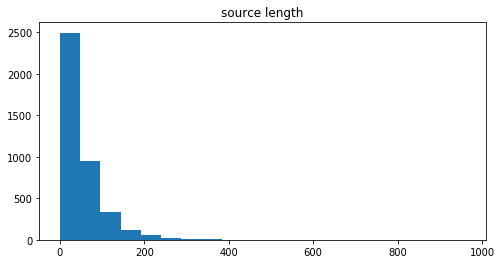

In [11]:
plt.figure(figsize=[8, 4])
plt.title("source length")
plt.hist(list(map(len, map(str.split, data_inp))), bins=20);

In [12]:
class BasicModel:
    def __init__(self, name, inp_voc, emb_size=64, hid_size=128):
        """
        A simple encoder- oder model
        """
        self.name, self.inp_voc = name, inp_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(inp_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(inp_voc))

            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            _, enc_last = tf.nn.dynamic_rnn(
                              self.enc0, inp_emb,
                              sequence_length=inp_lengths,
                              dtype = inp_emb.dtype)
        dec_start = self.dec_start(enc_last)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec] = prev_state
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        with tf.variable_scope('dec0'):
            new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)
        output_logits = self.logits(new_dec_out)
        return [new_dec_state], output_logits

    def translate_lines(self, inp_lines, max_len=5000):
        """
        Translates a list of lines by greedily selecting most likely next token at each step
        :returns: a list of output lines, a sequence of model states at each step
        """
        state = sess.run(self.initial_state, {self.inp: inp_voc.to_matrix(inp_lines)})
        outputs = [[self.inp_voc.bos_ix] for _ in range(len(inp_lines))]
        all_states = [state]
        finished = [False] * len(inp_lines)

        for t in range(max_len):
            state, logits = sess.run([self.next_state, self.next_logits], {**dict(zip(self.prev_state, state)),
                                           self.prev_tokens: [out_i[-1] for out_i in outputs]})
            next_tokens = np.argmax(logits, axis=-1)
            all_states.append(state)
            for i in range(len(next_tokens)):
                outputs[i].append(next_tokens[i])
                finished[i] |= next_tokens[i] == self.inp_voc.eos_ix
        return inp_voc.to_lines(outputs), all_states
    
        

In [13]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = BasicModel('model', inp_voc)
sess.run(tf.global_variables_initializer())

In [14]:
def compute_logits(model, inp, out, **flags):
    """
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    :returns: logits of shape [batch, time, voc_size]
    
    * logits must be a linear output of your neural network.
    * logits [:, 0, :] should always predic BOS
    * logits [:, -1, :] should be probabilities of last token in out
    This function should NOT return logits predicted when taking out[:, -1] as y_prev
    """
    batch_size = tf.shape(inp)[0]
    
    # Encode inp, get initial state
    first_state = model.encode(inp)
    
    # initial logits: always predict BOS
    first_logits = tf.log(tf.one_hot(tf.fill([batch_size], model.inp_voc.bos_ix),
                                     len(model.inp_voc)) + 1e-30)
    
    # Decode step
    def step(blob, y_prev):
        # Given previous state, obtain next state and next token logits
        prev_state, _ = blob
        state, logits = model.decode(prev_state, y_prev)
        return (state, logits)

    _, logits_seq = tf.scan(step,
           elems=tf.transpose(out),
           initializer=(first_state, first_logits)
           )
    
    
    logits_seq = tf.concat((tf.expand_dims(first_logits, axis=0), logits_seq[:-1]), axis=0)
    
    logits_seq = tf.transpose(logits_seq, perm=[1,0,2])
    
    return logits_seq

In [15]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use infer_length or infer_mask)
    """
    mask = infer_mask(out, inp_voc.eos_ix) 
    logits_seq = compute_logits(model, inp, out, **flags)
    softmaxed = tf.nn.softmax(logits_seq)
    softmaxed = select_values_over_last_axis(softmaxed, out)
    loss = -tf.reduce_sum(tf.multiply(tf.log(softmaxed), mask))/tf.reduce_sum(mask)
    
    return loss

In [16]:
dummy_inp = tf.constant(inp_voc.to_matrix(train_inp[:3]))
dummy_out = tf.constant(inp_voc.to_matrix(train_out[:3]))

NameError: name 'train_out' is not defined

In [ ]:
loss = sess.run(compute_loss(model, dummy_inp, dummy_out))

In [ ]:
print(loss)

In [ ]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
    translations, _ = model.translate_lines(inp_lines, **flags)
    return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [23]:
compute_bleu(model, dev_inp, dev_out)

0.7987506916493159

In [24]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)

train_step = tf.train.AdamOptimizer().minimize(loss)

In [25]:
metrics = {'train_loss': [], 'dev_bleu': [] }

sess.run(tf.global_variables_initializer())
batch_size = 32

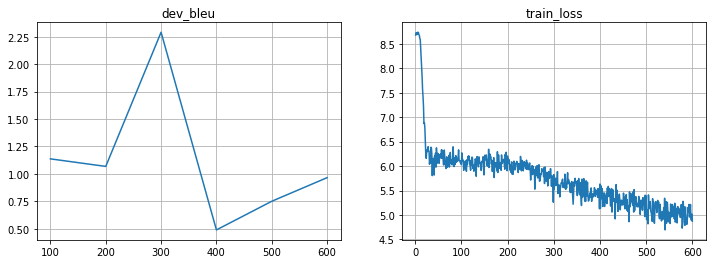

Mean loss=5.041


  3%|▎         | 691/25000 [04:24<2:34:47,  2.62it/s]

In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: inp_voc.to_matrix(train_inp[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        

In [29]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

35.29205636075493

In [30]:
np.mean(metrics['train_loss'][-10:])

12498.355041491985

In [36]:
for inp_line, trans_line in zip(dev_inp[4::500], model.translate_lines(dev_inp[4::500])[0]):
    print(inp_line)
    print()
    print(trans_line)

' this is a sma@@ sh ,' observed toby , biting his lips . ' there ' s more than one will go with this .'

' this is the matter with something ,' said the gentleman , producing a quicker dog ; ' it ' s a very form .'


In [58]:
test_inp_idx = inp_voc.to_matrix(train_inp)
test_inp_tnsr = tf.constant(test_inp_idx)

In [59]:
test_encoded = model.encode(test_inp_tnsr)

In [60]:
result = sess.run(test_encoded)

In [62]:
from sklearn.manifold import TSNE

In [63]:
%%time
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(result[0])

CPU times: user 53.2 s, sys: 14.8 s, total: 1min 7s
Wall time: 1min 7s


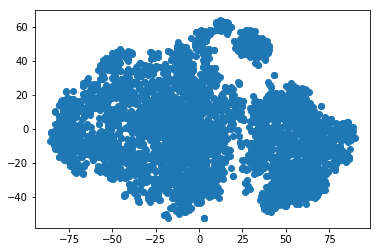

In [91]:
fig, ax = plt.subplots()
ax.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

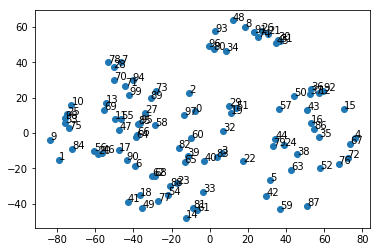

In [118]:
lb=0
rb=100
fig, ax = plt.subplots()
ax.scatter(tsne_representation[lb:rb, 0], tsne_representation[lb:rb, 1]);
for i, ix in enumerate(range(lb, rb)):
    ax.annotate(ix, (tsne_representation[i, 0], tsne_representation[i, 1]))

In [119]:
print(train_inp[8], end='\n\n')

' sum@@ mar@@ ily ,' replied mr . fang . ' he stands committed for three mon@@ th@@ shar@@ d labour of course . clear the office .'



In [121]:
for ix in [5,42,50,57,16,35,72,15]:
    print(train_inp[ix], end='\n\n')

again mr . brownlow nodded to mr . grimwig ; and again that gentleman limped away with extraordinary readiness . but not again did he return with a stout man and wife ; for this time , he led in two pal@@ sied women , who shook and tottered as they walked .

assi@@ sting oliver to rise , the young gentleman took him to an ad@@ jac@@ ent ch@@ and@@ ler ' s shop , where he purchased a sufficiency of ready - dressed ham and a half - quartern loaf , or , as he himself expressed it , ' a four@@ penny br@@ an !' the ham being kept clean and preserved from dust , by the ingenious expedient of making a hole in the loaf by pulling out a portion of the cru@@ mb , and stu@@ ff@@ ing it therein . taking the bread under his arm , the young gentlman turned into a small public - house , and led the way to a tap - room in the rear of the premises . here , a pot of beer was brought in , by direction of the mysterious youth ; and oliver , falling to , at his new friend ' s bidding , made a long and hear

In [122]:
for ix in [1,9,13,56,17,70,2,33,32]:
    print(train_inp[ix], end='\n\n')

' there ' s somebody to speak to there , at all event ,' he thought . ' a good hiding - place , too . they ' ll never expect to na@@ b me there , after this country scent . why can ' t i lie by for a week or so , and , forcing blunt from fagin , get abroad to fr@@ ance ? damme , i ' ll risk it .'

mrs . bumble , seeing at a glance , that the deci@@ sive moment had now arrived , and that a blow struck for the master@@ ship on one side or other , must necess@@ arily be final and conclu@@ sive , no sooner heard this allusion to the dead and gone , than she dropped into a chair , and with a loud scream that mr . bumble was a hard - hearted brute , fell into a paroxysm of tears .

' yes , yes !' interposed the jew , drawing up his chair .

now , mrs . corney that was , had tried the tears , because they were less troublesome than a manu@@ al assa@@ ult ; but , she was quite prepared to make trial of the latter mode of proceeding , as mr . bumble was not long in discovering .

' they fired a